In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import plotly.express as px
sns.set_theme(style='darkgrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
df =pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

In [5]:
df.describe

<bound method NDFrame.describe of      age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  

In [6]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

Let's perform auto EDA using Pandas Profiling as the data set isn't that big.

In [7]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [8]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling has provided us some quick insights. 
Luckily, there are no missing values. 

According to sex let's manually figure out the percentage of male/ female affected by heart attack.

In [9]:
# check for how many womens are prone to heart-attack
women_stroke = df.loc[df.sex == 0]['output']
women_stroke_percentage = sum(women_stroke)/len(women_stroke)
print('The % of women prone to heart-attack: {}%'.format(women_stroke_percentage*100))

The % of women prone to heart-attack: 75.0%


**Correlation**

------------------------------------------------------------------------------------------------------------------------------------------------------
output      1.000000
cp          0.433798
thalachh    0.421741
slp         0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trtbps     -0.144931
age        -0.225439
sex        -0.280937
thall      -0.344029
caa        -0.391724
oldpeak    -0.430696
exng       -0.436757
Name: output, dtype: float64


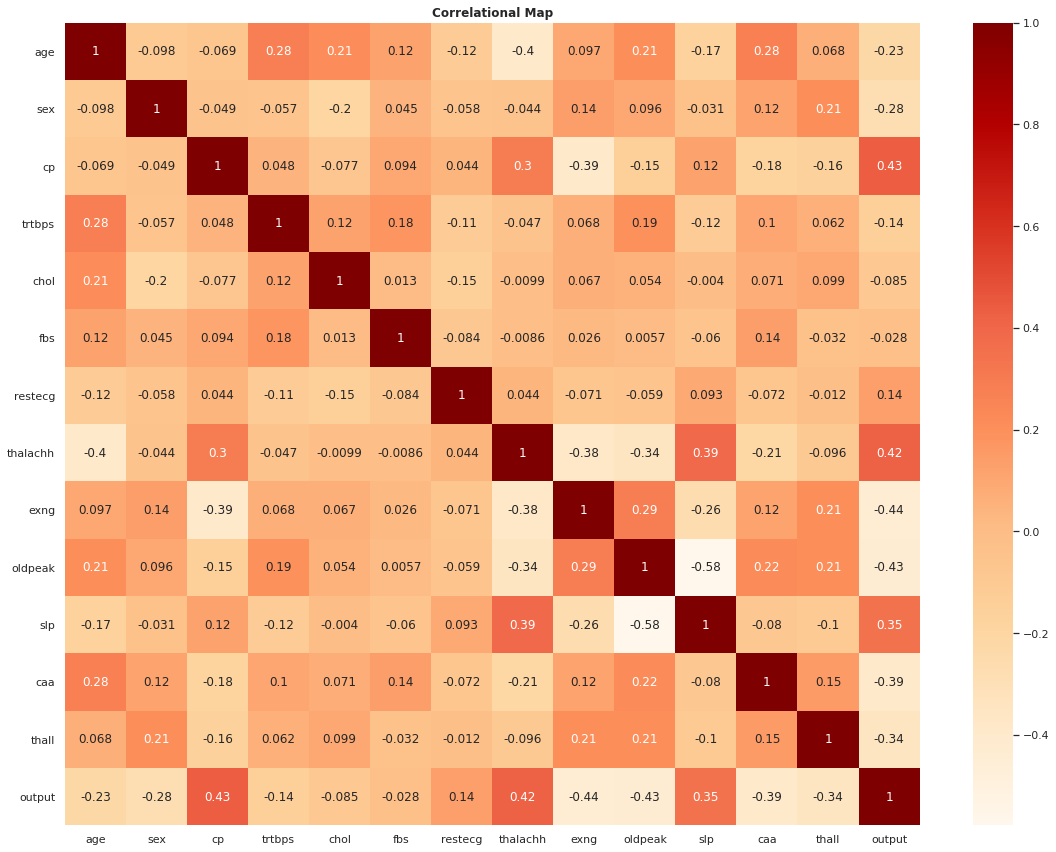

In [10]:
def find_correlational_map(data):
    plt.figure(figsize=(16,12))
    sns.heatmap(data.corr(), annot=True, cmap='OrRd')
    plt.title('Correlational Map', weight='bold')
    print('---'*50)
    print(data.corr().output.sort_values(ascending = False))
    plt.tight_layout()
    
find_correlational_map(df)

**Data Splitting**

In [11]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [13]:
# Let's split the date into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((242, 13), (61, 13))

In [14]:
y_train.shape, y_test.shape

((242,), (61,))

**Model Building**

In [15]:
# let's create a pipline 
pipeline = make_pipeline(RobustScaler()) # creating pipeline for model building

LR = make_pipeline(pipeline, LogisticRegression(random_state=0)) # LogisticRegression pipeline
DT = make_pipeline(pipeline, DecisionTreeClassifier(random_state=0)) # DecisionTree Classifier pipeline
RF = make_pipeline(pipeline, RandomForestClassifier(random_state=0)) # RandomForest Classifier pipeline
AC = make_pipeline(pipeline, AdaBoostClassifier(random_state=0)) # Adaboost Classifier pipeline
NB = make_pipeline(pipeline, GaussianNB()) # Naive bayes pipeline
KN = make_pipeline(pipeline, KNeighborsClassifier()) # KNeighbor pipeline
SV = make_pipeline(pipeline, SVC(random_state=0)) # Support vector pipeline

In [16]:
# creating model_dict
model_dictionary = {
    'Logistic_Regression':LR,
    'DecisionTree_Classifier':DT,
    'RandomForest_classifier':RF,
    'Adaboost_Classifier':AC,
    'Naivebayes_Classifier':NB,
    'KNeighbors_classifier':KN,
    'Support_Vector':SV
}

In [17]:
print(model_dictionary)

{'Logistic_Regression': Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('logisticregression', LogisticRegression(random_state=0))]), 'DecisionTree_Classifier': Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))]), 'RandomForest_classifier': Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))]), 'Adaboost_Classifier': Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))]), 'Naivebayes_Classifier': Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('robustscaler', RobustScaler())])),
                (

In [18]:
# define a function to fit the model and return it's accuracy, classification report and confusion matrix
def model_fitting(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('The accuracy score of the model is: {}%'.format(accuracy_score(y_test, y_pred)* 100))
    print('-----'*20)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

**Selecting the best model**

In [19]:
for name, model in model_dictionary.items():
    print('---'*10)
    print(name)
    model_fitting(model)

------------------------------
Logistic_Regression
The accuracy score of the model is: 83.60655737704919%
----------------------------------------------------------------------------------------------------
[[21  6]
 [ 4 30]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        27
           1       0.83      0.88      0.86        34

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

------------------------------
DecisionTree_Classifier
The accuracy score of the model is: 78.68852459016394%
----------------------------------------------------------------------------------------------------
[[22  5]
 [ 8 26]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        27
           1       0.84      0.76      0.80        34

    accuracy                           0.79        61

As we can see:

Ada boost has got 90% accuracy with only 6 misclassified classes.
It' has a precision of 0.86 for classes 0 and 0.94 for classes 1, which is better than all other algorithms.
**Let's use Adaboost Model**

In [20]:
model = AdaBoostClassifier(random_state=0)
model.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [21]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9016393442622951

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        27
           1       0.94      0.88      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



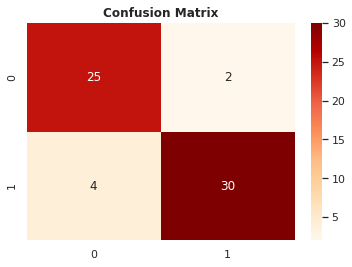

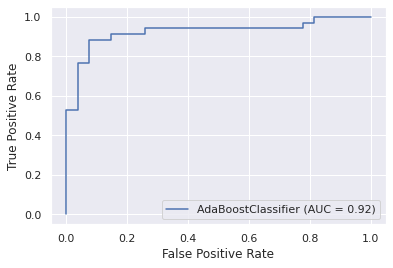

In [22]:
def find_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='OrRd')
    plt.title('Confusion Matrix', weight='bold')
    print(classification_report(y_test, y_pred))
    plot_roc_curve(model, X_test, y_test)
    
    
find_confusion_matrix(y_test, y_pred)

In [23]:
print('The accuracy of the model is: {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)))

The accuracy of the model is: 90.16%
